## Introduction to exponential Smoothing for Time Series Forecasting using Python

Exponential smoothing methods are used to forecast temperatures and uncover trends in time series data. In this notebook, I apply these methods to a dataset of monthly temperatures in Zahedan from 1970 to 2022, sourced from NASA's temperature dataset

**Import the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**upload the data**

In [2]:
df = pd.read_csv('zahedan.csv')

**We should apply preprocessing techniques to prepare the data for analysis.**

First, we need to create a dataframe with two columns: 'Date' and 'Temperature.' To do this, we will remove unnecessary columns and modify the dataframe as needed.

In [3]:
df.drop(['D-J-F', 'M-A-M', 'J-J-A', 'S-O-N', 'Temp'], axis=1, inplace=True)

In [4]:
df.rename(columns={"JAN":1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6,
                    'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}, inplace=True)
df.set_index('Year', inplace=True)
stacked_df = df.stack()
stacked_df = stacked_df.reset_index()

stacked_df.columns = ['Year', 'Month', 'Temp']
stacked_df['Date'] = stacked_df['Year'].astype(str) + '-' + stacked_df['Month'].astype(str)



**My desired dataframe is named 'df_main'.**

In [5]:
df_main = stacked_df.copy()
df_main.drop(columns=['Year', 'Month'], inplace=True)
df_main = df_main[['Date', 'Temp']]
df_main.head()

,Date,Temp
0,1970-1,7.79
1,1970-2,11.48
2,1970-3,12.86
3,1970-4,21.20
4,1970-5,25.75


**Now, we'll split the data into training and testing datasets, with 70% of the data allocated for training and 30% for testing**

In [6]:
train_data = df_main.iloc[:445]
test_data = df_main.iloc[445:]

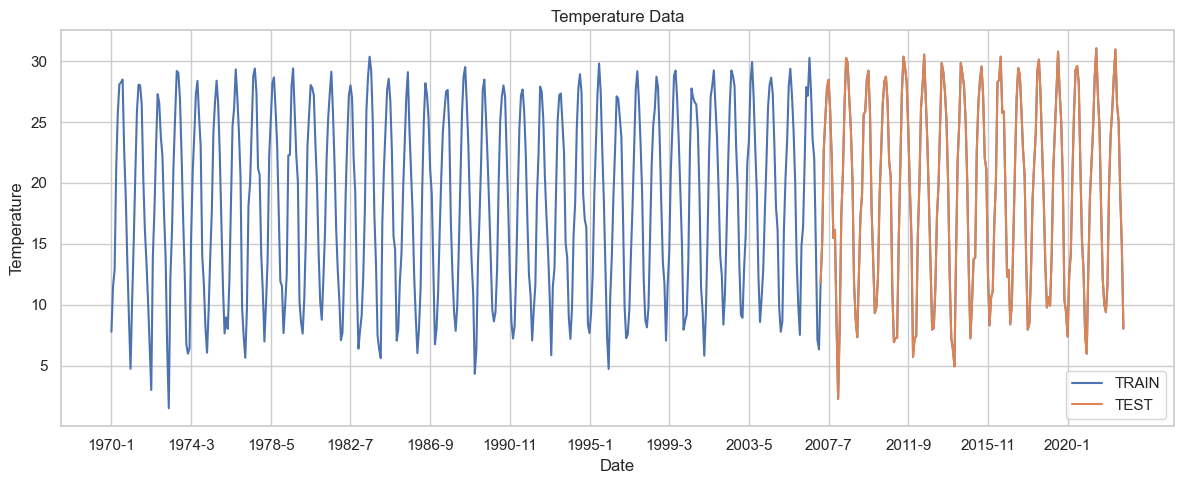

In [7]:
# Concatenate train_data and test_data
combined_data = pd.concat([train_data, test_data])

# Create a new index for displaying every 100 values
xlabels = combined_data.index
xlabels = xlabels[::50]

# Set the style for the Seaborn plot
sns.set(style="whitegrid")

# Create the Seaborn plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=combined_data, x=combined_data.Date, y='Temp', label='TRAIN', legend=True)

sns.lineplot(data=test_data, x=test_data.Date, y='Temp', label='TEST', legend=True)

# Set the x-axis labels
plt.xticks(xlabels)

# Add labels and a title (customize as needed)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Data')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()


Now, we are ready to apply seasonal decomposition techniques to our data.

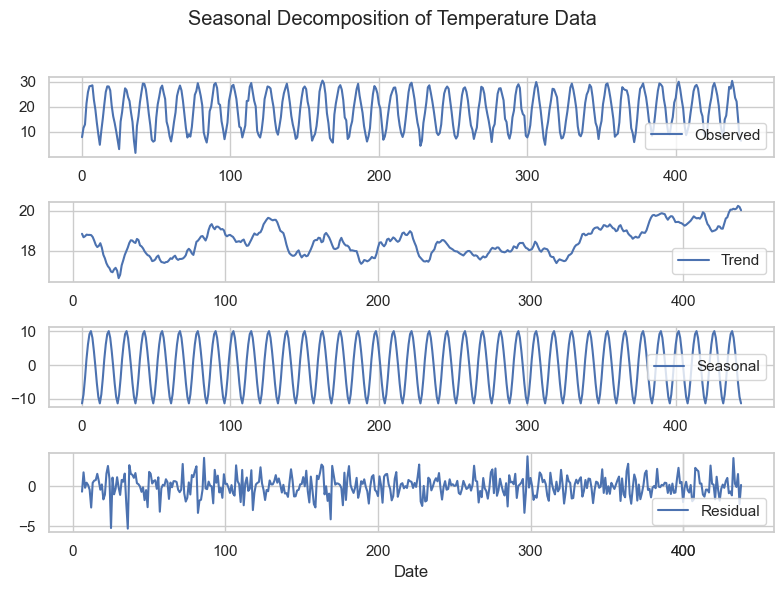

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition on train_data
result = seasonal_decompose(train_data['Temp'], period=12)

# Create the decomposition plot
plt.figure(figsize=(8, 6))

# Plot the observed component
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend()

# Plot the trend component
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

# Plot the seasonal component
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

# Plot the residual component
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()

# Set the x-axis labels
xlabels = train_data.index
xlabels = xlabels[::100]
xlabels = xlabels.append(pd.Index([xlabels[-1]]))
plt.xticks(xlabels)

# Add labels and a title (customize as needed)
plt.xlabel('Date')
plt.suptitle('Seasonal Decomposition of Temperature Data')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the subplot layout to make room for the suptitle
plt.savefig('seasonal_decomposition_plot.png', dpi=300, bbox_inches='tight') 
# Show the plot
plt.show()


Now, let's perform simple exponential smoothing. Simple Exponential Smoothing is a time series forecasting method for univariate data that doesn't consider the trend and seasonality in the input data during forecasting. The prediction is a weighted sum of past observations.

This method requires a single parameter known as alpha (𝛼), also referred to as the smoothing factor. Alpha controls how quickly the influence of past observations decays exponentially. Typically, alpha is set between 0 and 1. Larger values make the model focus on recent observations, while smaller values consider more historical data when making predictions.

In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
span = 12 # The model will consider the last 12 months weighted average for forecasting
alpha = 2/(span+1)
model = SimpleExpSmoothing(train_data['Temp']).fit(alpha)
test_predictions = model.forecast(191).rename('Temp')
predictions = pd.DataFrame(test_predictions)
predictions['Date'] = test_data['Date']
predictions = predictions[['Date', 'Temp']]

C:\Users\Amir\.conda\envs\weather\Lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


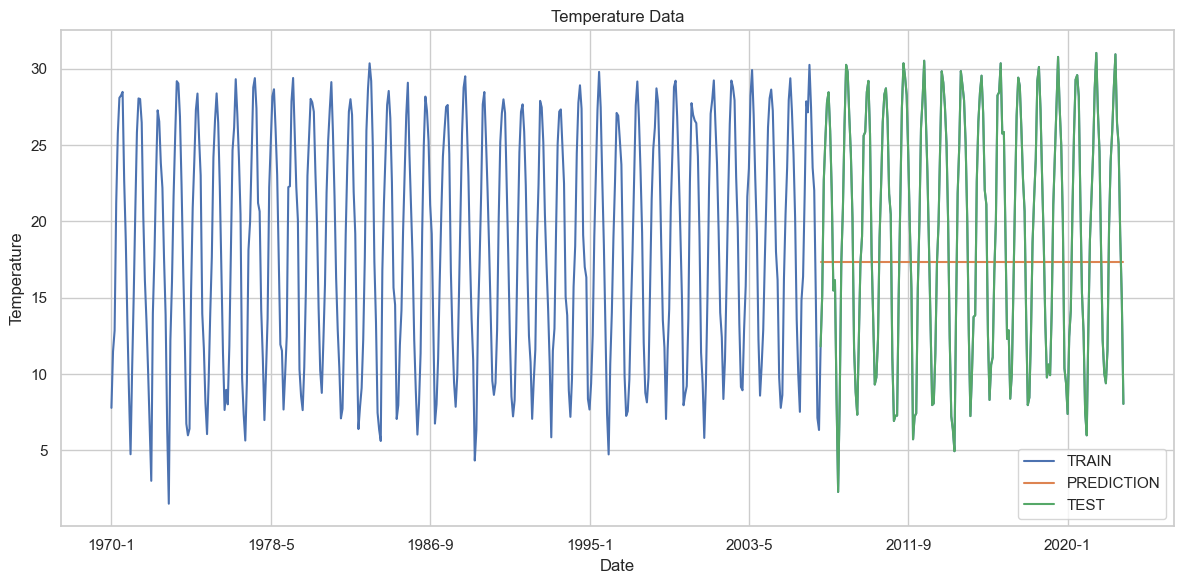

In [10]:
# Concatenate train_data and test_data
combined_data = pd.concat([train_data, test_data])

# Create a new index for displaying every 100 values
xlabels = combined_data.index
xlabels = xlabels[::100]

# Set the style for the Seaborn plot (optional)
sns.set(style="whitegrid")

# Create the Seaborn plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_data, x=combined_data.Date, y='Temp', label='TRAIN', legend=True)
sns.lineplot(data=predictions, x=predictions.Date, y='Temp', label='PREDICTION', legend=True)
sns.lineplot(data=test_data, x=test_data.Date, y='Temp', label='TEST', legend=True)

# Set the x-axis labels
plt.xticks(xlabels)

# Add labels and a title (customize as needed)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Data')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error
rms_error = np.sqrt(mean_squared_error(test_data['Temp'],test_predictions))
print("RMS Error is ",rms_error)

RMS Error is  8.01365455650484


**Double Exponential Smoothing**

Double Exponential Smoothing is an extension of Simple Exponential Smoothing that deals with trends in time series data. It introduces a new parameter, beta (𝛽), alongside the existing alpha, to manage the trend's influence.

There are two types of trend changes: additive and multiplicative. Additive Trend is for linear trends, while Multiplicative Trend suits exponential trends. The model's name for Double Exponential Smoothing with an additive trend is Holt’s linear trend model, named after its developer, Charles Holt.

For longer-range forecasts, trends can become unrealistic, so we can use beta to temper the trend's impact over time.

Key Hyperparameters:
- Alpha: Controls the level smoothing factor.
- Beta: Manages the trend smoothing factor.

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
double_model = ExponentialSmoothing(train_data['Temp'],trend='add').fit()
test_predictions = double_model.forecast(191).rename('Temp')
predictions = pd.DataFrame(test_predictions)
predictions['Date'] = test_data['Date']
predictions = predictions[['Date', 'Temp']]

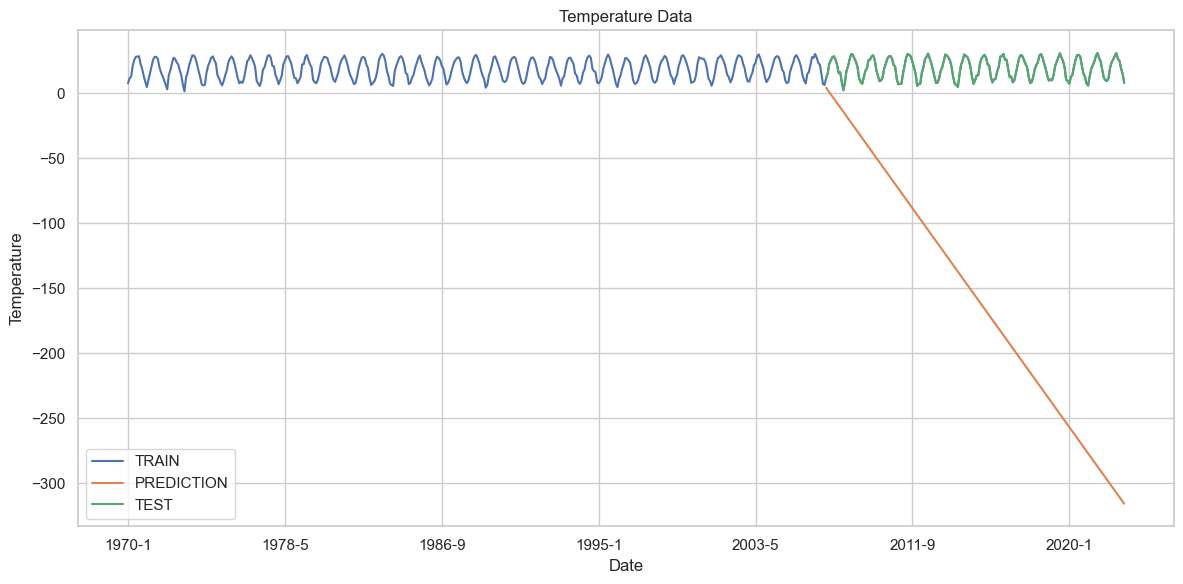

In [13]:
# Concatenate train_data and test_data
combined_data = pd.concat([train_data, test_data])

# Create a new index for displaying every 100 values
xlabels = combined_data.index
xlabels = xlabels[::100]

# Set the style for the Seaborn plot (optional)
sns.set(style="whitegrid")

# Create the Seaborn plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_data, x=combined_data.Date, y='Temp', label='TRAIN', legend=True)
sns.lineplot(data=predictions, x=predictions.Date, y='Temp', label='PREDICTION', legend=True)
sns.lineplot(data=test_data, x=test_data.Date, y='Temp', label='TEST', legend=True)

# Set the x-axis labels
plt.xticks(xlabels)

# Add labels and a title (customize as needed)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Data')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
rms_error = np.sqrt(mean_squared_error(test_data['Temp'],test_predictions))
print("RMS Error for DES is ",rms_error)

RMS Error for DES is  198.56593752346063


**Triple Exponential Smoothing**

Triple Exponential Smoothing, also known as Holt-Winters Exponential Smoothing, is an extension of Double Exponential Smoothing designed to account for seasonality in univariate time series data. It is named after its developers, Charles Holt and Peter Winters.

In addition to the alpha and beta smoothing factors for level and trend, a new parameter called gamma (𝛾) is introduced to control the influence of seasonality. The seasonality can be modeled as either additive or multiplicative, depending on whether it exhibits linear or exponential behavior.

Triple Exponential Smoothing is the most advanced variant of exponential smoothing and can adapt to double and single exponential smoothing configurations. To accurately model seasonality, you must specify the number of time steps in a seasonal period (Period). For instance, if you have monthly data with a yearly seasonal pattern, Period=12.

Hyperparameters:
- Alpha: Smoothing factor for the level.
- Beta: Smoothing factor for the trend.
- Gamma: Smoothing factor for seasonality.
- Trend Type: Additive or multiplicative.
- Seasonality Type: Additive or multiplicative.
- Period: Time steps in the seasonal period.

You can implement Triple Exponential Smoothing in Python using the Statsmodels class 'ExponentialSmoothing.' In your Python implementation, it's worth noting that you haven't specified the values for the parameters α, β, and γ, as the model will use default values.

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
triple_model = ExponentialSmoothing(train_data['Temp'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = triple_model.forecast(191).rename('Temp')
predictions = pd.DataFrame(test_predictions)
predictions['Date'] = test_data['Date']
predictions = predictions[['Date', 'Temp']]

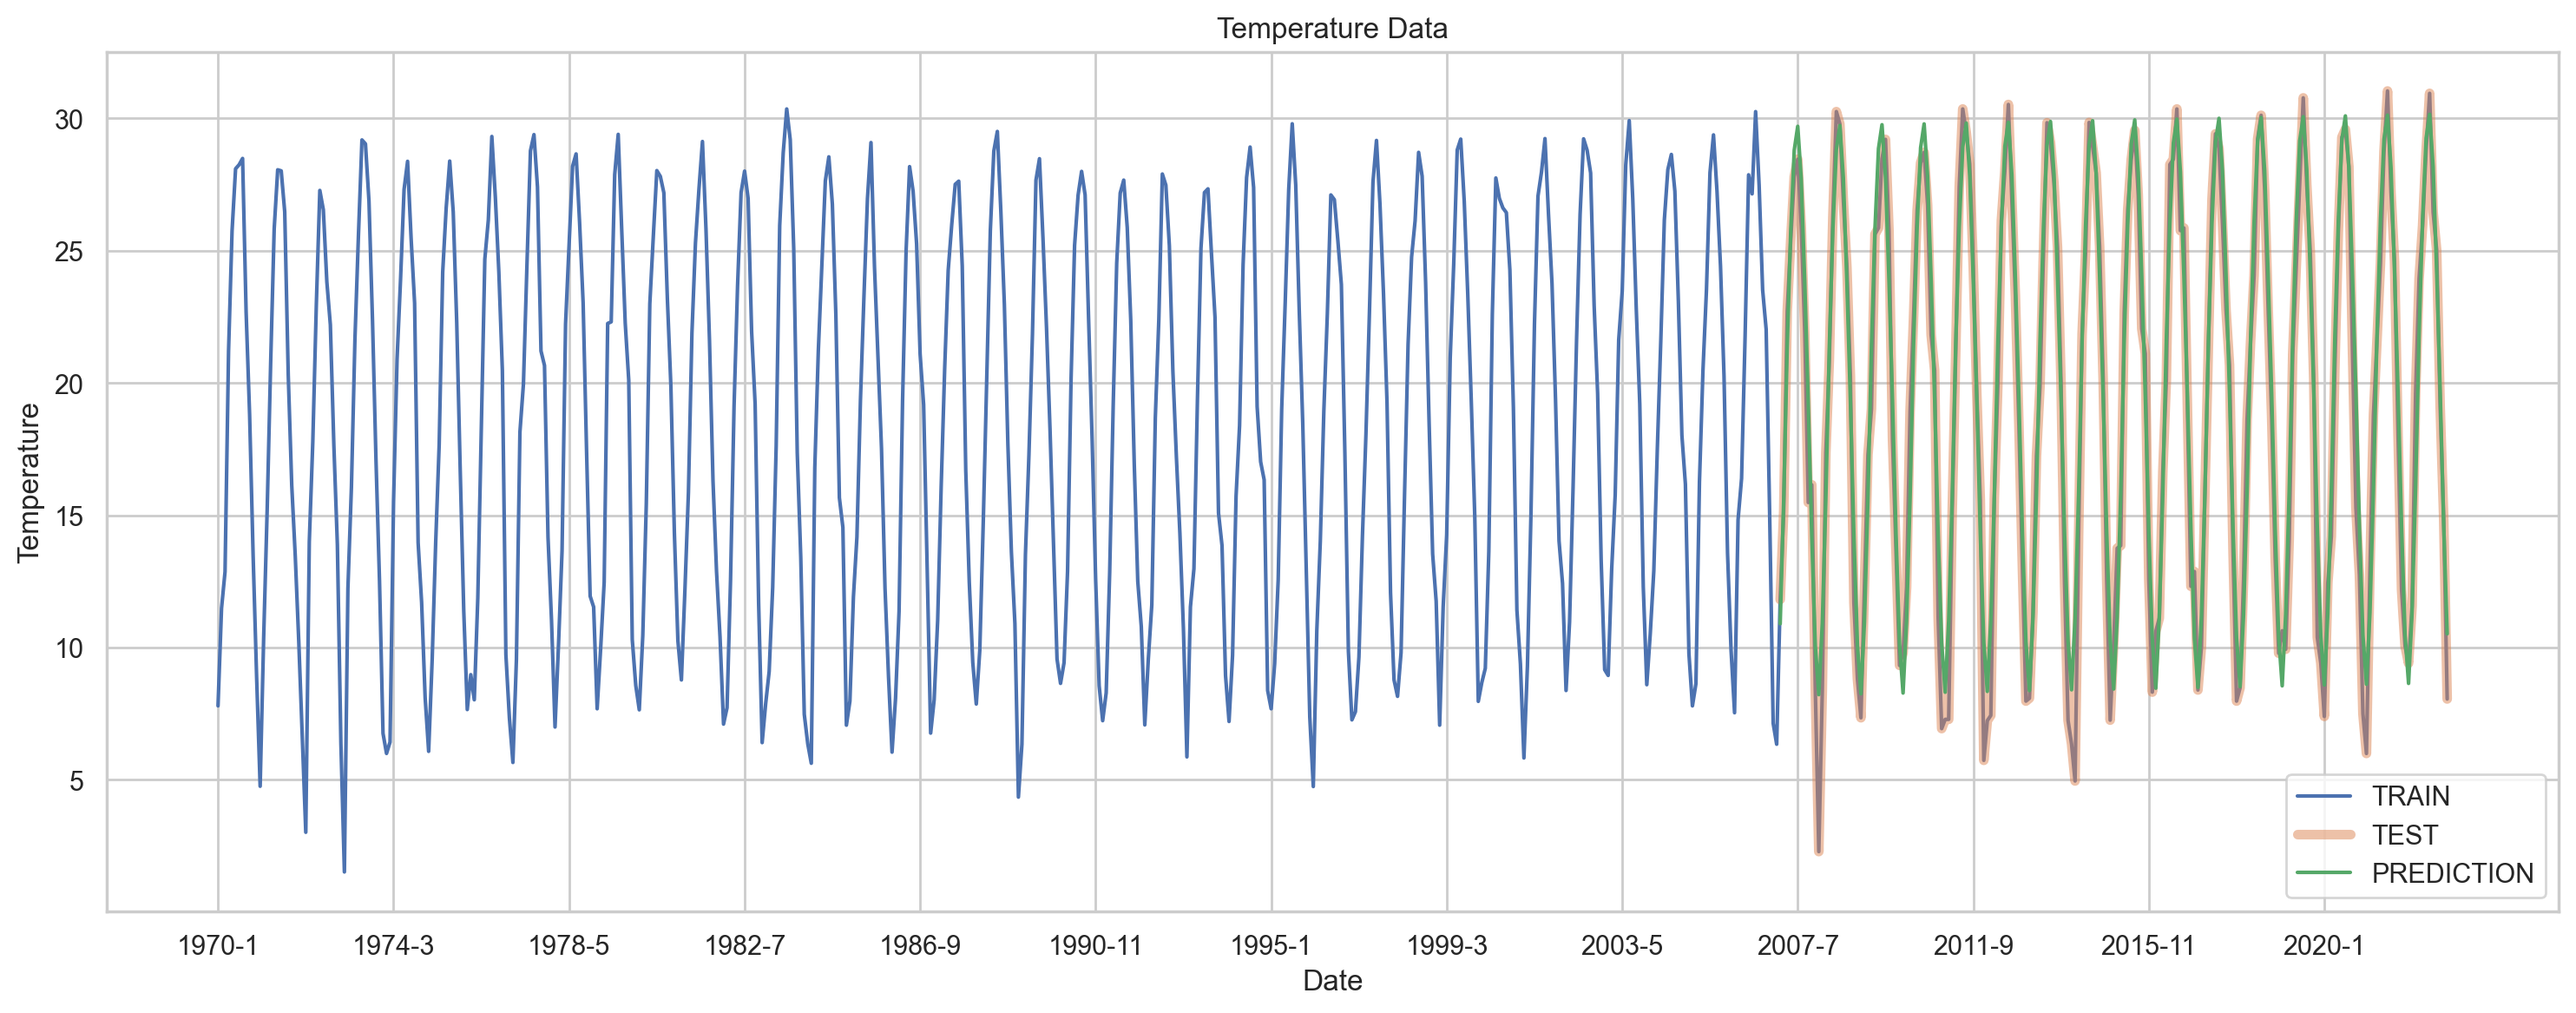

In [16]:
# Concatenate train_data and test_data
combined_data = pd.concat([train_data, test_data])

# Create a new index for displaying every 100 values
xlabels = combined_data.index
xlabels = xlabels[::50]

# Set the style for the Seaborn plot (optional)
sns.set(style="whitegrid")

# Create the Seaborn plot
plt.figure(figsize=(15, 6), dpi=200)
sns.lineplot(data=combined_data, x=combined_data.Date, y='Temp', label='TRAIN', legend=True, alpha=1)
sns.lineplot(data=test_data, x=test_data.Date, y='Temp', label='TEST', legend=True, alpha=0.5, linewidth=4)
sns.lineplot(data=predictions, x=predictions.Date, y='Temp', label='PREDICTION', legend=True)
# Set the x-axis labels
plt.xticks(xlabels)

# Add labels and a title (customize as needed)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Data')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
rms_error = np.sqrt(mean_squared_error(test_data['Temp'],test_predictions))
print("RMS Error for DES is ",rms_error)

RMS Error for DES is  1.7108078498242176
